# (PINN) -> 1D system (solution is exponentially decreasing + oscillatory)

# Tutorial example -> Equation to be solved ...

\begin{equation}
 \frac {dy} {dt} + 0.1 y - sin(\pi*t/2) = 0, \\
 \end{equation}
 with initial condition y(0) = 1.

# Used to make Figures 2 to 7 in Baty & Baty paper
## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Integration with order2 trapezoidal scheme rule between 0 and 30 ................
def oscillatorb():
    nSteps=3000              # number of time steps .................
    tMin,tMax = 0.0,30.0      # Time domain ....................
    tStep = (tMax-tMin)/nSteps   # Time tep ....................
    tPoints = np.arange(tMin, tMax, tStep)
    
    # set initial conditions on the state variables ....................
    y0 = 1.0
    y = [y0]

    # solve for the time evolution
    for t in tPoints[1:]:
        tdemi= t - tStep/2.
        ydemi = y[-1] + tStep/2.*( - 0.1*y[-1] + np.sin(np.pi*tdemi/2))        
        y.append(y[-1] + tStep * (- 0.1*ydemi + np.sin(np.pi*t/2)))  
        
    y = torch.Tensor(y)

    return torch.Tensor(tPoints).view(-1, 1), torch.Tensor(y).view(-1, 1)


class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true solution.


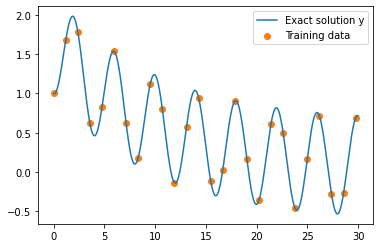

In [3]:
# We generate the exact solution and then slice to obtain training data ............
x, y = oscillatorb()
x = x[::1]
y = y[::1]

# ... slicing the true solution
#x_data=x[0:1800:29]
#y_data=y[0:1800:29]

x_data=x[0:3000:119]
y_data=y[0:3000:119]


plt.figure()
plt.plot(x, y, label="Exact solution y")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()


## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

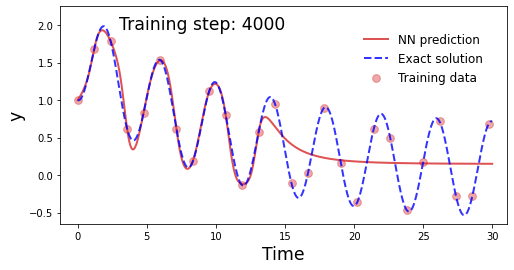

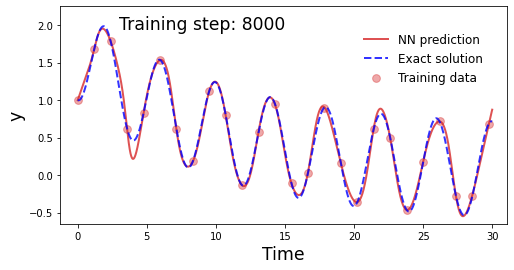

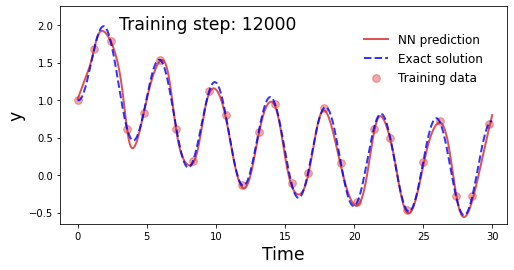

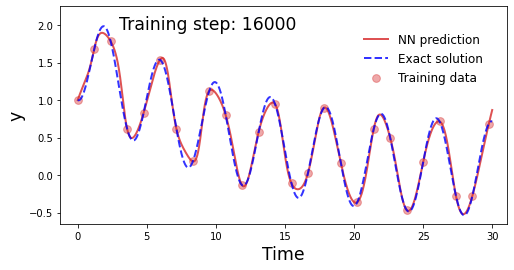

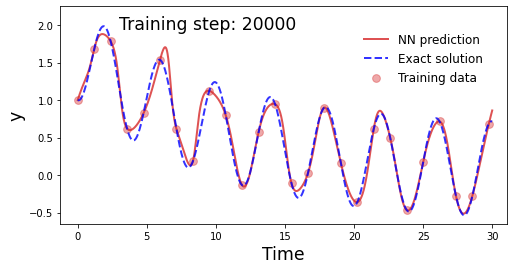

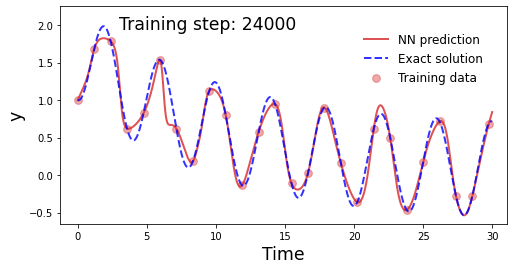

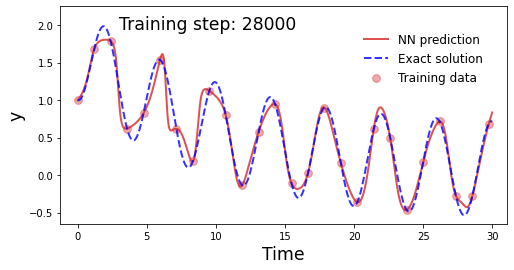

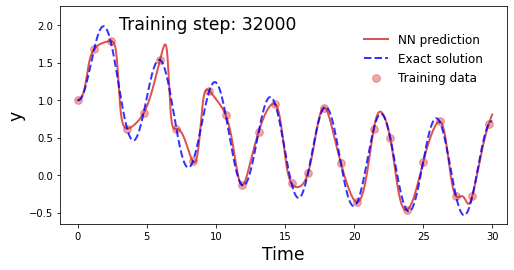

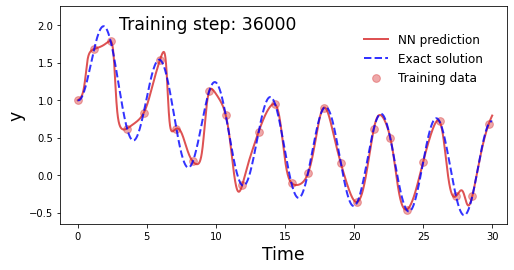

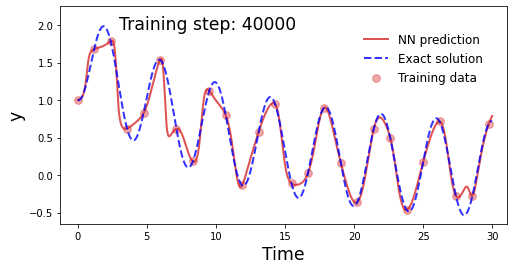

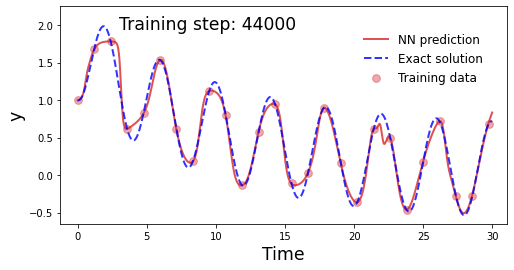

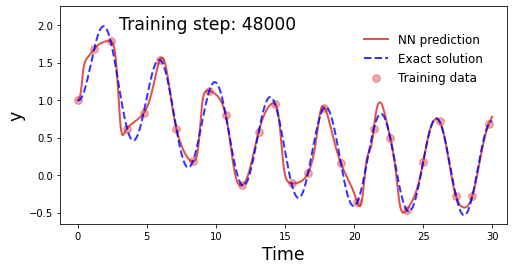

No handles with labels found to put in legend.


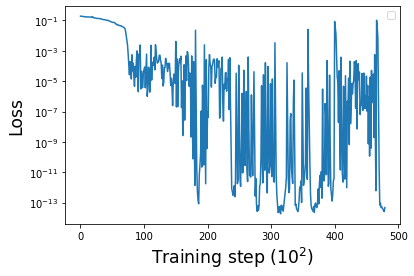

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Collocation points')
    l = plt.legend(loc=(0.67,0.62), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-1.25, 31.05)
    plt.ylim(-0.65, 2.25)
    plt.text(2.965,1.95,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.axis("on")
        
# train standard neural network to fit training data ..................
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []
loss11_history = []

for i in range(48000):
    optimizer.zero_grad()
    yh = model(x_data)
  
    loss = torch.mean((yh-y_data)**2)  # use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses ......................
    if (i+1) % 100 == 0: 
        loss11_history.append(loss.detach())  
        yh = model(x).detach()
              
        plot_result(x,y,x_data,y_data,yh)
        
    
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")
            
fig11 = plt.figure(11)
plt.plot(loss11_history)
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.ylabel('Loss',fontsize="xx-large")
plt.yscale('log')
plt.legend()

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at ...

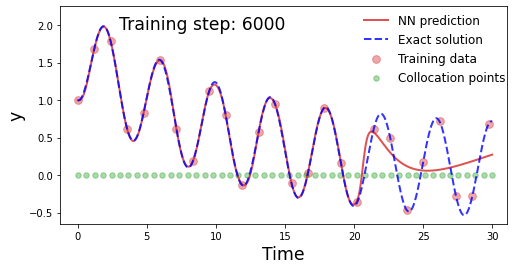

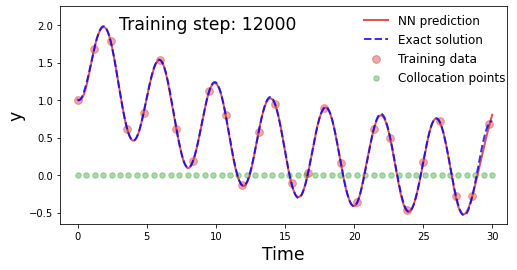

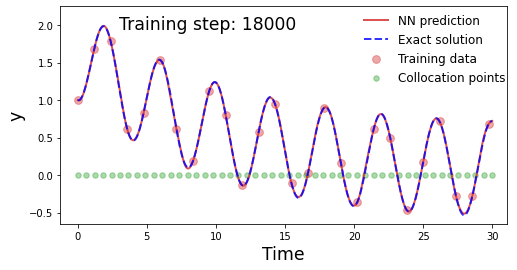

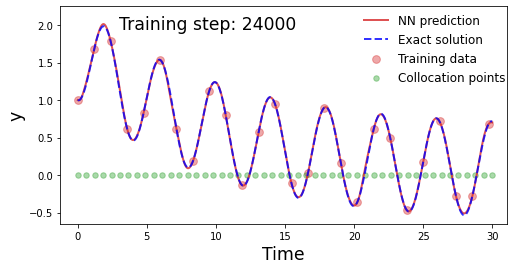

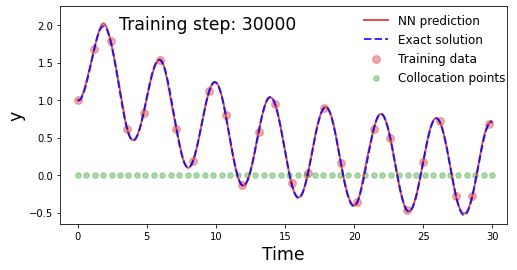

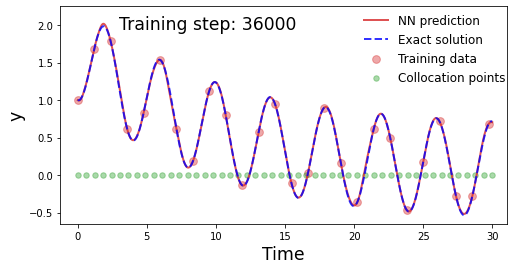

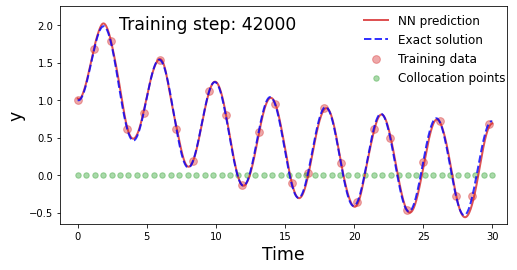

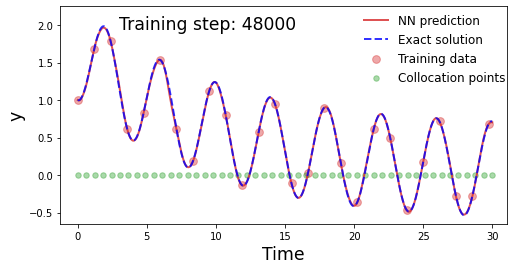

In [5]:
# We choose the colocation points for physics ......................................
x_physics = torch.linspace(0,30,50).view(-1,1).requires_grad_(True)# sample locations over the problem domain
lam=0.1

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []

loss_history = []
loss2_history = []
for i in range(48000):
    optimizer.zero_grad()
    
    # We compute the "data loss" .............................................
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)# use mean squared error
      
    # We compute the "physics loss" .............................................
    yhp = model(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  
      
    physics = (dx + lam*yhp - torch.sin(np.pi*x_physics/2))       
    loss2 = (6e-2)*(torch.mean(physics**2))
    
    # We backpropagate total loss ................................................
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # We plot the result as training progresses ....................................
    if (i+1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())

        yh = model(x).detach()
        xp = x_physics.detach()        
        plot_result(x,y,x_data,y_data,yh,xp)
                
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            

No handles with labels found to put in legend.


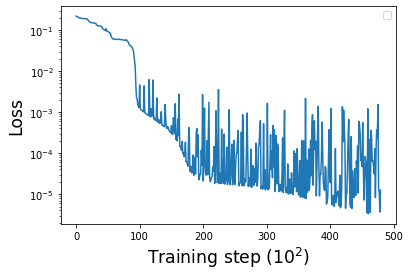

In [6]:
plt.plot(loss_history)
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.ylabel('Loss',fontsize="xx-large")
plt.yscale('log')
plt.legend()

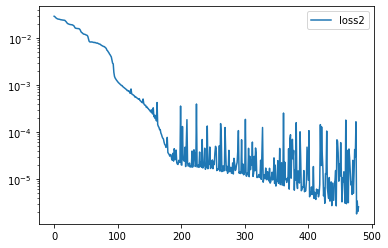

In [11]:
plt.plot(loss2_history, label="loss2")
plt.yscale('log')
plt.legend()